In [1]:
%pylab inline
import warnings
warnings.filterwarnings("ignore")
import nolearn
from nolearn.lasagne import NeuralNet
import readdata
import lasagne
from lasagne import layers
from sklearn import metrics
import detectobjects as det
import os.path
from scipy import misc
import cv2
from progress_bar import ProgressBar
import shapefeatures
from sklearn import ensemble
import dill as pickle

Populating the interactive namespace from numpy and matplotlib


In [2]:
opts = {'img_dir': 'data/tuberculosis-phonecamera/images/',
        'annotation_dir': 'data/tuberculosis-phonecamera/annotation/',
        'detection_probability_threshold': 0.5,
        'detection_overlap_threshold': 0.3, 
        'gauss': 1,
        'patch_size': (160,160),
        'image_downsample' : 8,
        'detection_step': 5,
        'patch_creation_step': 40,
        'object_class': None,
        'negative_training_discard_rate': .9
       }
opts['patch_stride_training'] = int(opts['patch_size'][0]*.25)

In [3]:
reload(readdata)

<module 'readdata' from 'readdata.pyc'>

In [4]:
trainfiles, valfiles, testfiles = readdata.create_sets(opts['img_dir'], train_set_proportion=.5, 
                                                  test_set_proportion=.5,
                                                  val_set_proportion=0)

train_y, train_X = readdata.create_patches(trainfiles, opts['annotation_dir'], opts['img_dir'], opts['patch_size'][0], opts['patch_stride_training'], grayscale=False, progressbar=True, downsample=opts['image_downsample'], objectclass=opts['object_class'], negative_discard_rate=opts['negative_training_discard_rate'])
test_y, test_X = readdata.create_patches(testfiles,  opts['annotation_dir'], opts['img_dir'], opts['patch_size'][0], opts['patch_stride_training'], grayscale=False, progressbar=True, downsample=opts['image_downsample'], objectclass=opts['object_class'], negative_discard_rate=opts['negative_training_discard_rate'])

# Cut down on disproportionately large numbers of negative patches
train_X, train_y = readdata.balance(train_X, train_y, mult_neg=100)
#test_X, test_y = readdata.balance(test_X, test_y, mult_neg=100)

# Create rotated and flipped versions of the positive patches
train_X, train_y = readdata.augment_positives(train_X, train_y)
test_X, test_y = readdata.augment_positives(test_X, test_y)

print '\n'
print '%d positive training examples, %d negative training examples' % (sum(train_y), len(train_y)-sum(train_y))
print '%d positive testing examples, %d negative testing examples' % (sum(test_y), len(test_y)-sum(test_y))
print '%d patches (%.1f%% positive)' % (len(train_y)+len(test_y), 100.*((sum(train_y)+sum(test_y))/(len(train_y)+len(test_y))))

[****************100%******************]  633 of 633 complete                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

View a random selection of positive and negative patches to see if they look right

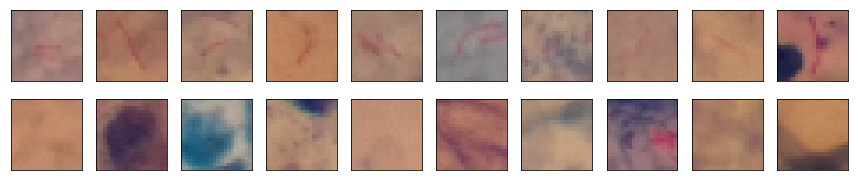

In [5]:
N_samples_to_display = 10
pos_indices = np.where(train_y)[0]
pos_indices = pos_indices[np.random.permutation(len(pos_indices))]
for i in range(N_samples_to_display):
    plt.subplot(2,N_samples_to_display,i+1)
    example_pos = train_X[pos_indices[i],:,:,:]
    example_pos = np.swapaxes(example_pos,0,2)
    plt.imshow(example_pos)
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')    

neg_indices = np.where(train_y==0)[0]
neg_indices = neg_indices[np.random.permutation(len(neg_indices))]
for i in range(N_samples_to_display,2*N_samples_to_display):
    plt.subplot(2,N_samples_to_display,i+1)
    example_neg = train_X[neg_indices[i],:,:,:]
    example_neg = np.swapaxes(example_neg,0,2)
    plt.imshow(example_neg)
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
plt.gcf().set_size_inches(1.5*N_samples_to_display,3)

### CNN training

In [6]:
def CNN(n_epochs):
    net1 = NeuralNet(
        layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),      #Convolutional layer.  Params defined below
        ('pool1', layers.MaxPool2DLayer),   # Like downsampling, for execution speed
        ('lstm', layers.LSTMLayer),
        ('output', layers.DenseLayer),
        ],
        
    input_shape=(None, 3, opts['patch_size'][0]/opts['image_downsample'], 
                 opts['patch_size'][0]/opts['image_downsample']),
    conv1_num_filters=7, 
    conv1_filter_size=(3, 3), 
    conv1_nonlinearity=lasagne.nonlinearities.rectify,
        
    pool1_pool_size=(2, 2),
        
    lstm_num_units=50,
       
    output_num_units=2, 
    output_nonlinearity=lasagne.nonlinearities.softmax,

    update_learning_rate=0.0001,
    update_momentum=0.9,

    max_epochs=n_epochs,
    verbose=1,
    )
    return net1

cnn = CNN(500).fit(train_X, train_y)

# Neural Network with 27448 learnable parameters

## Layer information

  #  name    size
---  ------  -------
  0  input   3x20x20
  1  conv1   7x18x18
  2  pool1   7x9x9
  3  lstm    7x50
  4  output  2

  epoch    trn loss    val loss    trn/val    valid acc  dur
-------  ----------  ----------  ---------  -----------  ------
      1     0.67066     0.65888    1.01786      0.60693  30.44s
      2     0.64204     0.61784    1.03917      0.67992  30.52s
      3     0.57668     0.53198    1.08403      0.77860  29.95s
      4     0.48704     0.44751    1.08834      0.83095  30.71s
      5     0.40714     0.37364    1.08966      0.86480  30.34s
      6     0.34064     0.31620    1.07731      0.88587  30.64s
      7     0.29060     0.27554    1.05467      0.90014  30.71s
      8     0.26080     0.25377    1.02770      0.90806  30.40s
      9     0.24251     0.23964    1.01199      0.91280  29.69s
     10     0.23022     0.23021    1.00005      0.91473  30.13s
     11     0.22157     0.224

     97     0.14346     0.15089    0.95076      0.94639  30.00s
     98     0.14308     0.15063    0.94993      0.94658  29.70s
     99     0.14270     0.15026    0.94969      0.94696  29.50s
    100     0.14234     0.14987    0.94977      0.94683  29.60s
    101     0.14207     0.14961    0.94957      0.94689  28.94s
    102     0.14172     0.14929    0.94928      0.94671  29.39s
    103     0.14149     0.14908    0.94910      0.94664  29.53s
    104     0.14105     0.14899    0.94673      0.94683  28.79s
    105     0.14095     0.14852    0.94902      0.94696  28.74s
    106     0.14048     0.14828    0.94739      0.94683  28.44s
    107     0.14012     0.14783    0.94783      0.94789  28.42s
    108     0.13986     0.14784    0.94599      0.94770  29.10s
    109     0.13974     0.14772    0.94596      0.94727  29.57s
    110     0.13923     0.14730    0.94517      0.94783  29.07s
    111     0.13924     0.14730    0.94528      0.94758  28.99s
    112     0.13891     0.14711    0.944

### Make predictions and evaluate on test data

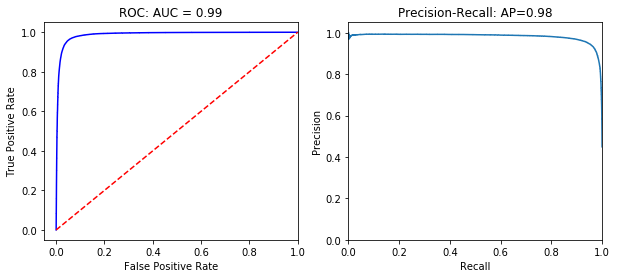

In [18]:
y_pred = cnn.predict_proba(test_X)

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(test_y, y_pred[:,1])
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)

precision, recall, thresholds = metrics.precision_recall_curve(test_y, y_pred[:,1])
average_precision = metrics.average_precision_score(test_y, y_pred[:, 1])

subplot(121)
plt.title('ROC: AUC = %0.2f'% roc_auc)
plt.plot(false_positive_rate, true_positive_rate, 'b')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.ylim([-.05, 1.05])
plt.xlim([-.05, 1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

subplot(122)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall: AP={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")

plt.gcf().set_size_inches(10,4)

plt.savefig('figs/tuberculosis-patchevaluation.png', bbox_inches='tight')

In [ ]:
y_pred = cnn.predict_proba(train_X)

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(train_y, y_pred[:,1])
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)

precision, recall, thresholds = metrics.precision_recall_curve(train_y, y_pred[:,1])
average_precision = metrics.average_precision_score(train_y, y_pred[:, 1])

subplot(121)
plt.title('ROC: AUC = %0.2f'% roc_auc)
plt.plot(false_positive_rate, true_positive_rate, 'b')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.ylim([-.05, 1.05])
plt.xlim([-.05, 1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

subplot(122)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall: AP={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")

plt.gcf().set_size_inches(10,4)

plt.savefig('figs/tuberculosis-patchevaluation.png', bbox_inches='tight')

In [22]:
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(test_y, y_pred[:,1])
true_positive_rate.shape, thresholds.shape
plt.plot(true_positive_rate, thresholds,label='True positive rate')
plt.plot(false_positive_rate, thresholds, label='False positive rate')
plt.xlabel('Threshold')
plt.ylim([0,1.01])
plt.legend(loc='upper left')

ValueError: Found input variables with inconsistent numbers of samples: [80514, 78937]

**Examine mistakes to understand network performance: false positives.** 

Find the negative-labelled patches with highest prediction score

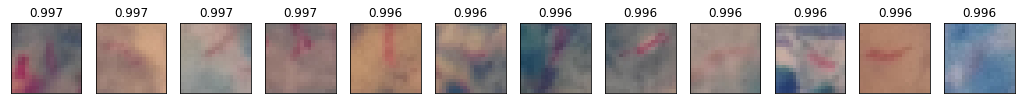

In [16]:
neg_indices = np.where(test_y==0)[0]
neg_scores = y_pred[neg_indices,1]
neg_indices = neg_indices[neg_scores.argsort()]
neg_indices = neg_indices[::-1]

neg_scores = y_pred[neg_indices,1]

N_samples_to_display = 12
offset = 55
for i in range(N_samples_to_display,2*N_samples_to_display):
    plt.subplot(2,N_samples_to_display,i+1)
    example_neg = test_X[neg_indices[i+offset],:,:,:]
    example_neg = np.swapaxes(example_neg,0,2)
    plt.imshow(example_neg)
    plt.title('%.3f' % neg_scores[i+offset])
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')    

plt.gcf().set_size_inches(1.5*N_samples_to_display,3) 

plt.savefig('figs/tuberculosis-falsedetections.png', bbox_inches='tight')

See highest-scored test patches

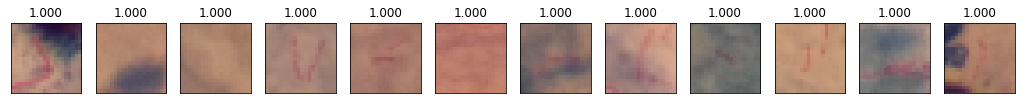

In [34]:
prob_range = [.95,1.]

tmp_scores = y_pred.copy()[:,1]
tmp_scores[tmp_scores<prob_range[0]] = -1
tmp_scores[tmp_scores>prob_range[1]] = -1

pos_indices = tmp_scores.argsort()
pos_indices = pos_indices[::-1]

N_samples_to_display = 12
offset = 0
for i in range(N_samples_to_display,2*N_samples_to_display):
    plt.subplot(2,N_samples_to_display,i+1)
    example_neg = test_X[pos_indices[i+offset],:,:,:]
    example_neg = np.swapaxes(example_neg,0,2)
    plt.imshow(example_neg)
    plt.title('%.3f' % (tmp_scores[pos_indices[i+offset]]))
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')    

plt.gcf().set_size_inches(1.5*N_samples_to_display,3) 

plt.savefig('figs/tuberculosis-detectedpatches.png', bbox_inches='tight')

See lowest scored test patches

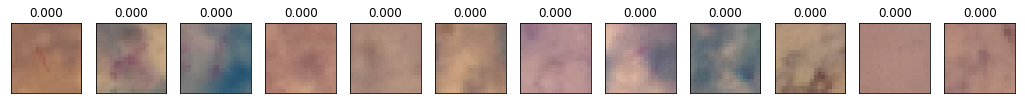

In [35]:
pos_indices = y_pred[:,1].argsort()

N_samples_to_display = 12

for i in range(N_samples_to_display,2*N_samples_to_display):
    plt.subplot(2,N_samples_to_display,i+1)
    example_neg = test_X[pos_indices[i],:,:,:]
    example_neg = np.swapaxes(example_neg,0,2)
    plt.imshow(example_neg)
    plt.title('%.3f' % (y_pred[pos_indices[i],1]))
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')    

plt.gcf().set_size_inches(1.5*N_samples_to_display,3) 

plt.savefig('figs/tuberculosis-testpatches-lowprob.png', bbox_inches='tight')

### Example of objects detected in an entire image

The white boxes represent annotations in the training data. Red boxes are detections by the convnet.

In [21]:
reload(det)

fname = testfiles[0]
imfile = opts['img_dir'] + fname
opts['detection_probability_threshold'] = 0.99
found = det.detect(imfile, cnn, opts)

im = misc.imread(imfile)

plt.box(False)
plt.xticks([])
plt.yticks([])

annofile = opts['annotation_dir'] + fname[:-3] + 'xml'
bboxes = readdata.get_bounding_boxes_for_single_image(annofile)
for bb in bboxes:
    bb = bb.astype(int)
    cv2.rectangle(im, (bb[0],bb[2]), (bb[1],bb[3]), (255,255,255), 8)  

for f in found:
    f = f.astype(int)
    cv2.rectangle(im, (f[0],f[1]), (f[2],f[3]), (255,0,0), 8)

plt.gcf().set_size_inches(10,10)
plt.title('Detected objects in %s' % (imfile))
plt.imshow(im)

#cv2.imwrite('detectionimages/detected-' + os.path.basename(imfile),im)

TypeError: 'float' object cannot be interpreted as an index

### Evaluation: compare with classification based on morphological feature extraction

In [45]:
featureset = [3,7,11,12,15,17]
centiles = [0,25,50,75,100]

pb = ProgressBar(train_X.shape[0])
train_X_f = []
for i in range(train_X.shape[0]):
    if i % 100 == 0:
        pb.step(i)
    graypatch = cv2.cvtColor(np.swapaxes(train_X[i,:,:,:],0,2).astype('uint8'), cv2.COLOR_BGR2GRAY)
    train_X_f.append(shapefeatures.extract(graypatch,attributes=featureset,centiles=centiles, momentfeatures=True))
train_X_f = np.vstack(train_X_f)

test_X_f = []
for i in range(test_X.shape[0]):
    if i % 100 == 0:
        pb.step(i)
    graypatch = cv2.cvtColor(np.swapaxes(test_X[i,:,:,:],0,2).astype('uint8'), cv2.COLOR_BGR2GRAY)
    test_X_f.append(shapefeatures.extract(graypatch,attributes=featureset,centiles=centiles, momentfeatures=True))
test_X_f = np.vstack(test_X_f)

[                  0%                  ]

OSError: ./libshapefeatures.so: cannot open shared object file: No such file or directory

In [46]:
clf = ensemble.ExtraTreesClassifier(n_estimators=100, max_depth=5, n_jobs=-1)
clf.fit(train_X_f, train_y)
y_pred_CLF = clf.predict_proba(test_X_f)

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [47]:
false_positive_rate_CNN, true_positive_rate_CNN, thresholds_CNN = metrics.roc_curve(test_y, y_pred[:,1])
roc_auc_CNN = metrics.auc(false_positive_rate_CNN, true_positive_rate_CNN)

precision_CNN, recall_CNN, thresholds_CNN = metrics.precision_recall_curve(test_y, y_pred[:,1])
average_precision_CNN = metrics.average_precision_score(test_y, y_pred[:, 1])

false_positive_rate_CLF, true_positive_rate_CLF, thresholds_CLF = metrics.roc_curve(test_y, y_pred_CLF[:,1])
roc_auc_CLF = metrics.auc(false_positive_rate_CLF, true_positive_rate_CLF)

precision_CLF, recall_CLF, thresholds_CLF = metrics.precision_recall_curve(test_y, y_pred_CLF[:,1])
average_precision_CLF = metrics.average_precision_score(test_y, y_pred_CLF[:, 1])

subplot(211)
plt.title('ROC' )
plt.plot(false_positive_rate_CNN, true_positive_rate_CNN, 'b', label='CNN: AUC=%.2f' % (roc_auc_CNN))
plt.plot(false_positive_rate_CLF, true_positive_rate_CLF, 'k--', label='ERT: AUC=%.2f' % (roc_auc_CLF))
plt.legend(loc='lower right')
plt.ylim([-.05, 1.05])
plt.xlim([-.05, 1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

subplot(212)
plt.plot(recall_CNN, precision_CNN, label='CNN: AP=%.2f' % (average_precision_CNN))
plt.plot(recall_CLF, precision_CLF,'k--', label='ERT: AP=%.2f' % (average_precision_CLF))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall')
plt.legend(loc="lower left")

plt.gcf().set_size_inches(4,10)

plt.savefig('figs/tuberculosis-patchevaluation.png', bbox_inches='tight')

ValueError: Found input variables with inconsistent numbers of samples: [80534, 79166]

In [48]:
results = {
"false_positive_rate_CNN": false_positive_rate_CNN,
"true_positive_rate_CNN": true_positive_rate_CNN,
"false_positive_rate_CLF": false_positive_rate_CLF,
"true_positive_rate_CLF": true_positive_rate_CLF,
"roc_auc_CNN": roc_auc_CNN,
"roc_auc_CLF": roc_auc_CLF,
"recall_CNN": recall_CNN,
"precision_CNN": precision_CNN,
"average_precision_CNN": average_precision_CNN,
"recall_CLF": recall_CLF,
"precision_CLF": precision_CLF,
"average_precision_CLF": average_precision_CLF,
"opts": opts
}
import pickle
pickle.dump(results,open('tuberculosis-results.pkl','w'))

NameError: name 'false_positive_rate_CNN' is not defined